In [1]:
import kwant
import semicon

import numpy as np
import scipy.linalg as la
import scipy.sparse.linalg as sla

import matplotlib.pyplot as plt
%matplotlib inline

# semicon related code

In [2]:
widths = [5, 12.5, 5, 5]
grid_spacing = 0.5
gamma_0 = 1.0

model = semicon.models.ZincBlende(
    components=('foreman',),
    parameter_coords='z', 
    default_databank='lawaetz'
)

AlSb = model.parameters('AlSb', valence_band_offset=.18).renormalize(new_gamma_0=gamma_0)
InAs = model.parameters('InAs').renormalize(new_gamma_0=gamma_0)
GaSb = model.parameters('GaSb', valence_band_offset=.56).renormalize(new_gamma_0=gamma_0)

two_deg_params, walls = semicon.misc.two_deg(
    parameters = [AlSb, InAs, GaSb, AlSb],
    widths = widths,
    grid_spacing=grid_spacing,
    extra_constants=semicon.parameters.constants,
)

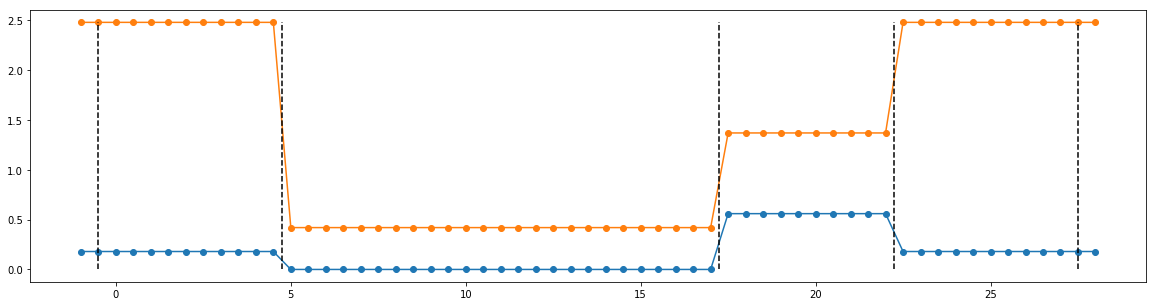

In [3]:
import numpy as np

xpos = np.arange(- 2 * grid_spacing, sum(widths) + 2 * grid_spacing, 0.5)
semicon.misc.plot_2deg_bandedges(two_deg_params, xpos, walls);

# standard python and kwant code

In [4]:
template = kwant.continuum.discretize(model.hamiltonian, coords='z', grid_spacing=grid_spacing)

shape = lambda site: 0 - grid_spacing / 2 < site.pos[0] < sum(widths)

syst = kwant.Builder()
syst.fill(template, shape, (0, ))
syst = syst.finalized()

In [5]:
%%time

momenta = np.linspace(-.45, .45, 101)
energies = []
for k in momenta:
    p = {'k_x': k, 'k_y': 0, **two_deg_params}
    ham = syst.hamiltonian_submatrix(params=p, sparse=True)
    ev, evec = sla.eigsh(ham, k=20, sigma=.52)
    energies.append(ev)

CPU times: user 21.1 s, sys: 28.5 s, total: 49.6 s
Wall time: 13.2 s


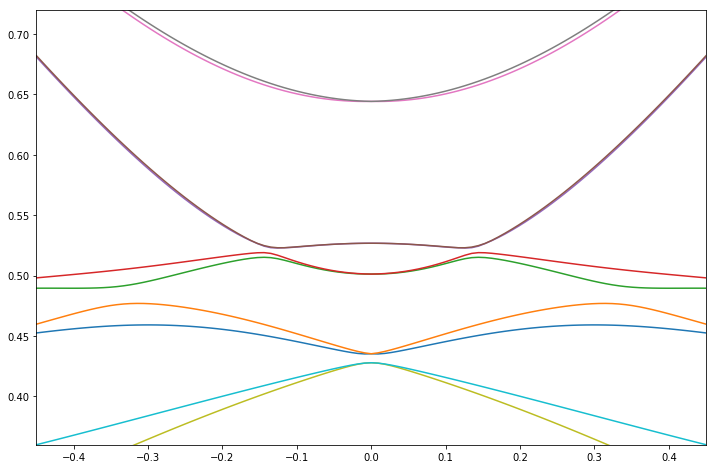

In [6]:
plt.figure(figsize=(12, 8))

plt.plot(momenta, np.sort(energies))

plt.xlim(min(momenta), max(momenta))
plt.ylim(0.36, .72);